In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from scipy.optimize import minimize

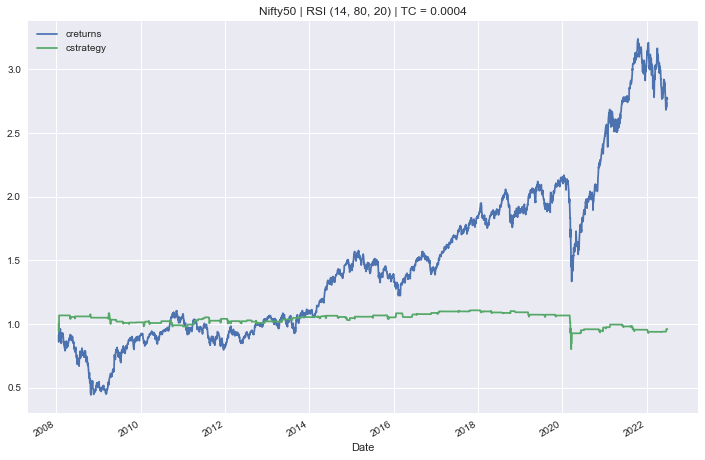

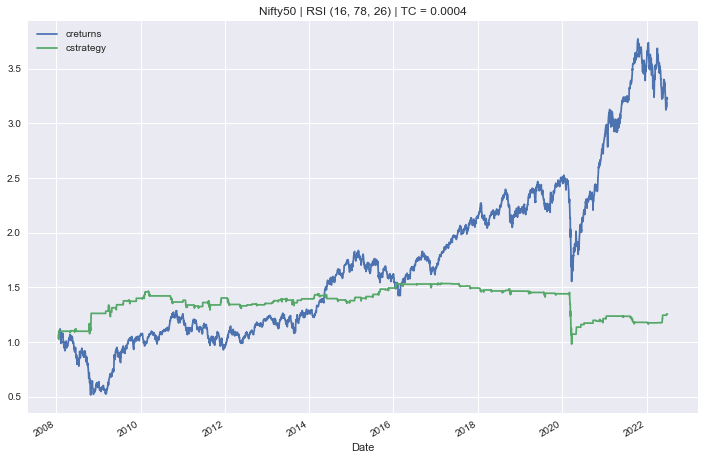

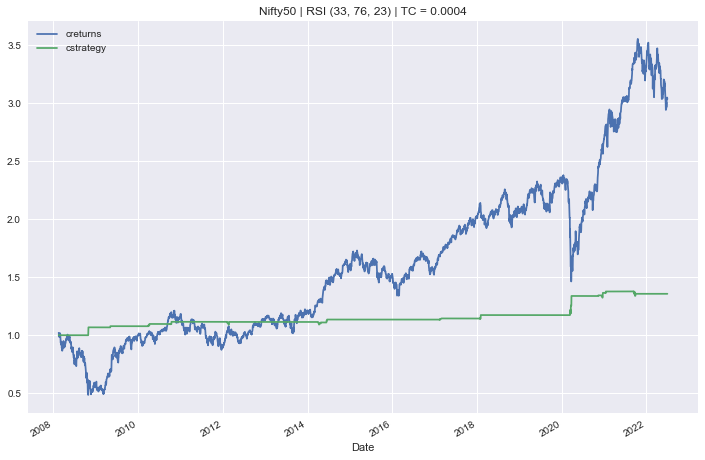

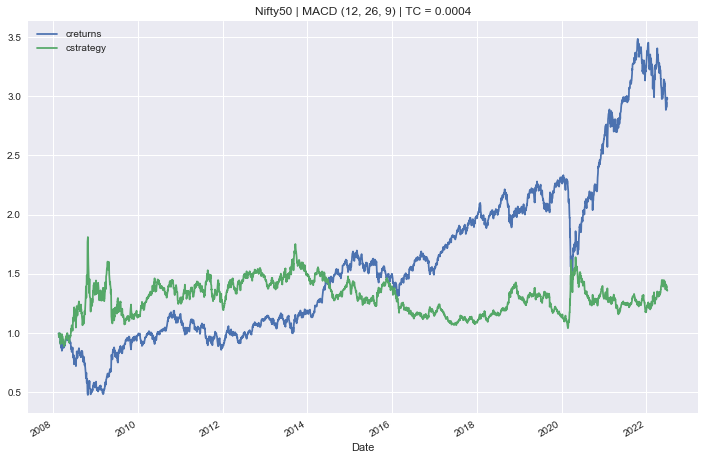

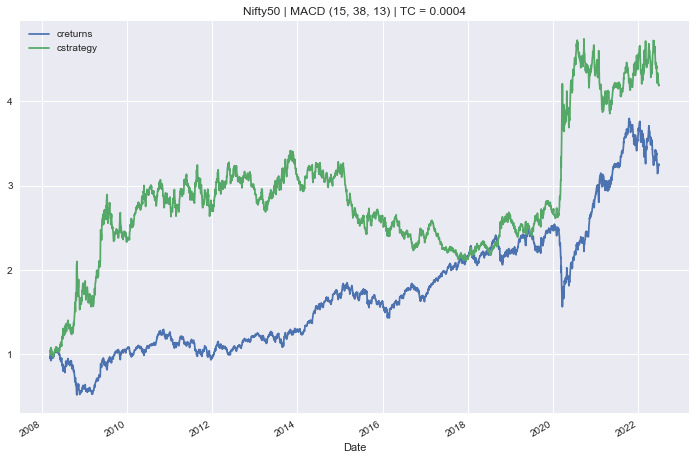

In [2]:
import RSI
import MACD

In [3]:
def optimal_strategy(parameters):
    
    start = "2008-01-01"
    end = "2022-07-01"
    symbol = "Nifty50"
    tc = 0.0004
    
    # SMA
    tester1 = RSI.RSIBacktester(symbol, int(parameters[0]), int(parameters[1]), int(parameters[2]), start, end, tc)
    tester1.test_strategy()
    
    # Bollinger
    tester2 = MACD.MACDBacktester(symbol,  int(parameters[3]),  int(parameters[4]), int(parameters[5]), start, end, tc)
    tester2.test_strategy()
    
    # Create comb
    comb = tester1.results.loc[:, ["returns", "position"]].copy()
    comb.rename(columns = {"position":"position_RSI"}, inplace = True)
    comb["position_MACD"] = tester2.results.position
    
    comb["position_comb"] = np.sign(comb.position_MACD + comb.position_RSI)
    
    # Backtest
    comb["strategy"] = comb["position_comb"].shift(1) * comb["returns"]
    comb.dropna(inplace=True)
    comb["trades"] = comb.position_comb.diff().fillna(0).abs()
    comb.strategy = comb.strategy - comb.trades * tc
    comb["creturns"] = comb["returns"].cumsum().apply(np.exp)
    comb["cstrategy"] = comb["strategy"].cumsum().apply(np.exp)
    
    return -comb["cstrategy"].iloc[-1]


In [4]:
optimal_strategy((14, 70, 30, 12, 26, 9))

-0.8023594913416697

In [5]:
bnds = ((10, 20), (60, 80), (20, 40), (5, 20), (20, 50), (5, 20))

In [6]:
start_par = (14, 70, 30, 12, 26, 9)

In [7]:
opts = minimize(optimal_strategy, start_par, method = "Powell" , bounds = bnds)

In [8]:
opts

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [-2.80929834, -7.06318393, 10.11500274,  1.69996397, -1.44787405,
        -7.02041981]])
     fun: -3.526269752525913
 message: 'Optimization terminated successfully.'
    nfev: 406
     nit: 3
  status: 0
 success: True
       x: array([16.4560851 , 74.85730903, 24.73834718, 12.1714253 , 45.76520359,
       14.69467115])

In [9]:
optimal_strategy(opts.x)

-3.526269752525913